In [46]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt

from scipy.stats import randint
from scipy.special import boxcox
from scipy.special import inv_boxcox

pd.set_option('display.max_columns', None)

In [47]:
def calculate_alpha_beta(mean,var):
    return var/mean , mean/(var/mean)

In [48]:
def pearson_corr_2(x, y):
    x_diff = x - np.mean(x)
    y_diff = y - np.mean(y)
    r2_c = (np.dot(x_diff, y_diff) / (np.sqrt(sum(x_diff ** 2)) * np.sqrt(sum(y_diff ** 2)))) ** 2
    return r2_c

In [49]:
def check_deviation(group):
    values = group['Est_AC_POWER'].values
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            if abs(values[i] - values[j]) / max(values[i], values[j]) > 0.5:
                return True
    return False

In [50]:
# dataset = pd.read_csv('dataset.csv')
dataset = pd.read_csv('cleand_dataset.csv')
dataset

,Unnamed: 0.1,Unnamed: 0,TRIP_ID,SUB_ID,SEGMENT_ID,START_TIME,END_TIME,START_LATITUDE,START_LONGITUDE,LAST_LATITUDE,LAST_LONGITUDE,START_ALTITUDE,LAST_ALTITUDE,AVG_ALTITUDE,START_SOC,END_SOC,START_GIDS,END_GIDS,SOH,AVG_SPEED,RUN_TIME,TRIP_TIME,DROP_TIME,BETTERY_TEMPERATURA,AMBIENT_TEMPERATURA,EV_POWER,RUN_POWER,AUX_POWER,AC_POWER,Est_AC_POWER,ALL_Consumption_Wh,RUN_Consumption_Wh,AUX_Consumption_Wh,AC_Consumption_Wh,EST_AC_Consumption_Wh,TEMPERATURE_yokohama,TEMPERATURE_ebina,HUMIDITY,WIND_SPEED_yokohama,WIND_SPEED_ebina,ILLUMINANCE,PRECIPITATION_START_yokohama,PRECIPITATION_END_yokohama,PRECIPITATION_START_ebina,PRECIPITATION_END_ebina,WEATHER,ILLUMINANCE_Log,TRIP_TEMPERATURE,AVG_TEMPERATURE,AVG_PRECIPITATION_START,AVG_PRECIPITATION_END
0,0,0,2707,1,0,2020-09-01 09:30:00,2020-09-01 09:30:00,35.431556,139.413903,35.434622,139.421987,41.3,45.3,35.819355,776202,773806,597,596,98.69,10.436903,354.0,354.0,43200.0,27.690681,24.978495,2524.632576,1996.675586,200.000000,327.956989,367.204301,243.066324,191.802435,19.666667,31.597222,35.680556,25.600000,25.700001,17.888339,4.600000,4.100000,24192.337812,0.0,0.0,0.0,0.0,雨のち曇,4,26.483461,25.650001,0.0,0.0
1,1,1,2707,1,1,2020-09-01 09:30:00,2020-09-01 09:40:00,35.434701,139.422333,35.438742,139.431251,46.5,43.2,45.473171,773638,771892,595,594,98.69,23.109366,508.0,154.0,0.0,27.708130,25.719512,3209.735710,2589.004003,200.000000,420.731707,396.341463,134.928004,108.386338,8.555556,17.986111,16.944444,25.643903,25.721952,17.914867,4.578049,4.085366,24600.018545,0.0,0.0,0.0,0.0,雨のち曇,4,26.483461,25.682927,0.0,0.0
2,2,2,2707,1,2,2020-09-01 09:40:00,2020-09-01 09:50:00,35.438919,139.431633,35.441024,139.441819,44.6,50.0,49.774026,771772,766854,594,590,98.69,6.710727,1422.0,914.0,0.0,27.765584,27.064935,2182.220074,1501.700594,193.506494,487.012987,461.038961,364.103035,251.214146,32.055556,80.833333,76.625000,26.145455,26.163636,18.195588,4.081818,4.063636,24169.265531,0.0,0.0,0.0,0.0,雨のち曇,4,26.483461,26.154546,0.0,0.0
3,3,3,2707,1,3,2020-09-01 09:50:00,2020-09-01 09:50:00,35.441013,139.442262,35.439788,139.451153,50.0,48.4,48.525000,766703,765473,590,589,98.69,34.443000,1513.0,91.0,0.0,27.818056,27.312500,3675.155801,3183.489135,200.000000,291.666667,347.916667,92.601239,80.184573,5.055556,7.361111,8.805556,26.100000,26.299999,18.149506,3.900000,4.200000,19507.008057,0.0,0.0,0.0,0.0,雨のち曇,3,26.483461,26.200000,0.0,0.0
4,4,4,2707,1,4,2020-09-01 09:50:00,2020-09-01 09:50:00,35.439790,139.451290,35.438597,139.458691,48.5,36.8,47.263830,765531,763833,589,588,98.69,25.067490,1689.0,176.0,0.0,27.846809,26.978723,1715.359026,1265.359026,200.000000,250.000000,335.106383,90.322610,68.322610,9.777778,12.222222,16.388889,26.100000,26.299999,18.149506,3.900000,4.200000,19507.008057,0.0,0.0,0.0,0.0,雨のち曇,3,26.483461,26.200000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15347,17464,17464,4560,1,22,2023-08-30 10:50:00,2023-08-30 10:50:00,35.449129,139.567853,35.452739,139.576851,57.7,64.2,59.858333,728318,726240,522,521,91.97,70.764000,3817.0,51.0,0.0,32.358333,32.833333,8988.018412,8038.018412,200.000000,750.000000,666.666667,123.898511,110.440178,2.833333,10.625000,9.444444,31.900000,31.799999,20.857681,5.200000,3.500000,38488.187489,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,31.849999,0.0,0.0
15348,17465,17465,4560,1,23,2023-08-30 10:50:00,2023-08-30 11:00:00,35.452996,139.577632,35.458544,139.585216,60.5,34.8,46.375000,726224,726472,521,521,91.97,70.881001,3868.0,51.0,0.0,32.366667,33.000000,-1109.831677,-2059.831677,200.000000,750.000000,716.666667,-15.617443,-29.075777,2.833333,10.625000,10.166667,31.900000,31.974999,21.109992,5.150000,3.400000,37195.114358,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,31.937500,0.0,0.0
15349,17466,17466,4560,1,24,2023-08-30 11:00:00,2023-08-30 11:00:00,35.459174,139.585967,35.465691,139.591233,32.4,24.4,24.725000,726530,72

In [51]:
features = ['RUN_TIME','DROP_TIME','AVG_SPEED','AVG_ALTITUDE','AVG_TEMPERATURE','HUMIDITY','ILLUMINANCE_Log','AVG_PRECIPITATION_START','AVG_PRECIPITATION_END']
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

dataset_groupby = dataset.groupby(['TRIP_ID']).sum(numeric_only=True)
id_list = dataset_groupby[(dataset_groupby['EST_AC_Consumption_Wh']>50)].index.tolist()
dataset = dataset[dataset['TRIP_ID'].isin(id_list)]

DBSCANを用いて、特徴量が類似しているが、目標値に大きな差異があるデータを除外しました（モデルを適用した結果が良くなかったため、採用しません）。

In [52]:
# cluster_df = dataset[features].copy()
# clustering = DBSCAN(eps=3, min_samples=2).fit(cluster_df)
# cluster_df['cluster'] = clustering.labels_

# Outliers_df = cluster_df[cluster_df['cluster'] != -1]
# Outliers_df = Outliers_df.join(dataset[['TRIP_ID','Est_AC_POWER']])
# remove_outliers = Outliers_df.groupby('cluster').filter(check_deviation)

# id_list = list(remove_outliers['TRIP_ID'].unique())
# dataset_remove_by_DBSCAN = dataset[dataset['TRIP_ID'].isin(id_list)]

グリッドサーチ

In [53]:
param_grid = {
    'n_estimators': list(range(20, 151, 10)),
    'learning_rate': [0.01, 0.31, 0.05]
}

xgb_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(poly.fit_transform(dataset[features]), boxcox(dataset['Est_AC_POWER'], 0.24))

print("best params:", grid_search.best_params_)

best params: {'learning_rate': 0.05, 'n_estimators': 100}


ランダムサーチ

In [54]:
# param_distributions = {
#     'n_estimators': randint(10, 200),
#     'max_depth': [None] + list(range(10, 31, 10)),
#     'min_samples_split': randint(2, 10)
# }

# rf = RandomForestRegressor()
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=50, cv=3, n_jobs=-1, random_state=99)
# random_search.fit(poly.fit_transform(dataset[features]), boxcox(dataset['Est_AC_POWER'], 0.24))
# print("best params:", random_search.best_params_)

10分割交差検定
特徴量を多項式変換
目標値をboxcox変換

In [55]:
dataset.reset_index(inplace=True)
kfold_groups = dataset['TRIP_ID'].unique()
kf = KFold(n_splits=10, shuffle=True, random_state=50)

result_real = []
result_pred = []

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_metric': 'rmse',
    'learning_rate': grid_search.best_params_['learning_rate'],
    'gpu_id': 0 
}

for train_index, test_index in kf.split(kfold_groups):

    train = dataset[dataset['TRIP_ID'].isin(kfold_groups[train_index])]
    test = dataset[dataset['TRIP_ID'].isin(kfold_groups[test_index])]
    
    X_train = poly.fit_transform(train[features])
    X_test = poly.fit_transform(test[features])
    
#     Y_train = train['Est_AC_POWER']
#     Y_test = test['Est_AC_POWER']
    
    Y_train = boxcox(train['Est_AC_POWER'], 0.24)
    Y_test = boxcox(test['Est_AC_POWER'], 0.24)
    
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_test, label=Y_test)
    
    xgboost = xgb.train(params, dtrain, num_boost_round=grid_search.best_params_['n_estimators'], evals=[(dtest, 'test')])
    
    Y_pred = xgboost.predict(dtest)
    
#     result_real.append(list(Y_test))
#     result_pred.append(list(Y_pred))
#     dataset.loc[test.index, 'Pred_AC_POWER'] = list(Y_pred)
    
    result_real.append(list(inv_boxcox(Y_test, 0.24)))
    result_pred.append(list(inv_boxcox(Y_pred, 0.24)))
    dataset.loc[test.index, 'Pred_AC_POWER'] = list(inv_boxcox(Y_pred, 0.24))

[0]	test-rmse:11.27214
[1]	test-rmse:10.75486
[2]	test-rmse:10.26532
[3]	test-rmse:9.80188
[4]	test-rmse:9.36262
[5]	test-rmse:8.94696
[6]	test-rmse:8.55748
[7]	test-rmse:8.19063
[8]	test-rmse:7.84526
[9]	test-rmse:7.51602
[10]	test-rmse:7.20564
[11]	test-rmse:6.91323
[12]	test-rmse:6.63739
[13]	test-rmse:6.37488
[14]	test-rmse:6.12636
[15]	test-rmse:5.89479
[16]	test-rmse:5.67595
[17]	test-rmse:5.46913
[18]	test-rmse:5.28016
[19]	test-rmse:5.10335
[20]	test-rmse:4.93567
[21]	test-rmse:4.78463
[22]	test-rmse:4.63800
[23]	test-rmse:4.50139
[24]	test-rmse:4.36909
[25]	test-rmse:4.24739
[26]	test-rmse:4.13569
[27]	test-rmse:4.03147
[28]	test-rmse:3.93406
[29]	test-rmse:3.84505
[30]	test-rmse:3.76265
[31]	test-rmse:3.68510
[32]	test-rmse:3.62910
[33]	test-rmse:3.56491
[34]	test-rmse:3.50439
[35]	test-rmse:3.44446
[36]	test-rmse:3.39415
[37]	test-rmse:3.34823
[38]	test-rmse:3.30427
[39]	test-rmse:3.26493
[40]	test-rmse:3.22398
[41]	test-rmse:3.18959
[42]	test-rmse:3.15866
[43]	test-rmse:3.1

C:\Users\ELMO_HX\AppData\Local\Temp\ipykernel_17464\3860988921.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[test.index, 'Pred_AC_POWER'] = list(inv_boxcox(Y_pred, 0.24))


[43]	test-rmse:2.98460
[44]	test-rmse:2.96062
[45]	test-rmse:2.93782
[46]	test-rmse:2.91814
[47]	test-rmse:2.90113
[48]	test-rmse:2.88766
[49]	test-rmse:2.87042
[50]	test-rmse:2.86122
[51]	test-rmse:2.84786
[52]	test-rmse:2.83367
[53]	test-rmse:2.82444
[54]	test-rmse:2.81574
[55]	test-rmse:2.80924
[56]	test-rmse:2.80239
[57]	test-rmse:2.79725
[58]	test-rmse:2.79255
[59]	test-rmse:2.78840
[60]	test-rmse:2.78456
[61]	test-rmse:2.78167
[62]	test-rmse:2.77982
[63]	test-rmse:2.77868
[64]	test-rmse:2.77586
[65]	test-rmse:2.77307
[66]	test-rmse:2.77119
[67]	test-rmse:2.77263
[68]	test-rmse:2.77364
[69]	test-rmse:2.77326
[70]	test-rmse:2.77208
[71]	test-rmse:2.77124
[72]	test-rmse:2.76614
[73]	test-rmse:2.76324
[74]	test-rmse:2.76350
[75]	test-rmse:2.76210
[76]	test-rmse:2.76447
[77]	test-rmse:2.76377
[78]	test-rmse:2.76349
[79]	test-rmse:2.76112
[80]	test-rmse:2.76256
[81]	test-rmse:2.76157
[82]	test-rmse:2.76053
[83]	test-rmse:2.75990
[84]	test-rmse:2.75982
[85]	test-rmse:2.76096
[86]	test-r

[1]	test-rmse:10.30639
[2]	test-rmse:9.83438
[3]	test-rmse:9.38315
[4]	test-rmse:8.95839
[5]	test-rmse:8.55981
[6]	test-rmse:8.17889
[7]	test-rmse:7.82055
[8]	test-rmse:7.48710
[9]	test-rmse:7.16617
[10]	test-rmse:6.87218
[11]	test-rmse:6.59293
[12]	test-rmse:6.33002
[13]	test-rmse:6.08064
[14]	test-rmse:5.84701
[15]	test-rmse:5.62448
[16]	test-rmse:5.41453
[17]	test-rmse:5.22232
[18]	test-rmse:5.03663
[19]	test-rmse:4.86141
[20]	test-rmse:4.70080
[21]	test-rmse:4.55427
[22]	test-rmse:4.41500
[23]	test-rmse:4.28554
[24]	test-rmse:4.16699
[25]	test-rmse:4.05269
[26]	test-rmse:3.94698
[27]	test-rmse:3.85088
[28]	test-rmse:3.76079
[29]	test-rmse:3.67689
[30]	test-rmse:3.60020
[31]	test-rmse:3.52891
[32]	test-rmse:3.46351
[33]	test-rmse:3.40630
[34]	test-rmse:3.35225
[35]	test-rmse:3.30083
[36]	test-rmse:3.25719
[37]	test-rmse:3.21670
[38]	test-rmse:3.18151
[39]	test-rmse:3.14850
[40]	test-rmse:3.11446
[41]	test-rmse:3.08713
[42]	test-rmse:3.05638
[43]	test-rmse:3.03405
[44]	test-rmse:3.01

[59]	test-rmse:2.26437
[60]	test-rmse:2.25882
[61]	test-rmse:2.25280
[62]	test-rmse:2.24614
[63]	test-rmse:2.24476
[64]	test-rmse:2.23919
[65]	test-rmse:2.23364
[66]	test-rmse:2.22941
[67]	test-rmse:2.22714
[68]	test-rmse:2.22541
[69]	test-rmse:2.22436
[70]	test-rmse:2.22194
[71]	test-rmse:2.21835
[72]	test-rmse:2.21585
[73]	test-rmse:2.21440
[74]	test-rmse:2.21266
[75]	test-rmse:2.20717
[76]	test-rmse:2.20471
[77]	test-rmse:2.20467
[78]	test-rmse:2.20417
[79]	test-rmse:2.20299
[80]	test-rmse:2.20091
[81]	test-rmse:2.20047
[82]	test-rmse:2.20000
[83]	test-rmse:2.19968
[84]	test-rmse:2.19747
[85]	test-rmse:2.19539
[86]	test-rmse:2.19526
[87]	test-rmse:2.19292
[88]	test-rmse:2.19286
[89]	test-rmse:2.19458
[90]	test-rmse:2.19443
[91]	test-rmse:2.19600
[92]	test-rmse:2.19633
[93]	test-rmse:2.19593
[94]	test-rmse:2.19566
[95]	test-rmse:2.19691
[96]	test-rmse:2.19703
[97]	test-rmse:2.19746
[98]	test-rmse:2.19714
[99]	test-rmse:2.19874
[0]	test-rmse:11.29436
[1]	test-rmse:10.79322
[2]	test-rm

In [56]:
print('rmse:',sqrt(mean_squared_error(dataset['Est_AC_POWER'],dataset['Pred_AC_POWER'])))
print('r2:',r2_score(dataset['Est_AC_POWER'],dataset['Pred_AC_POWER']))

rmse: 161.0754559368655
r2: 0.7073156615797038


In [57]:
df_result = dataset.copy()
df_result['Real_Wh'] = list(df_result.Est_AC_POWER*df_result.TRIP_TIME/3600)
df_result['Pred_Wh'] = list(df_result.Pred_AC_POWER*df_result.TRIP_TIME/3600)
print(r2_score(df_result['Real_Wh'].tolist(),df_result['Pred_Wh'].tolist()))
print(pearson_corr_2(df_result['Real_Wh'].tolist(),df_result['Pred_Wh'].tolist()))

0.8198256519589362
0.8247374391158622


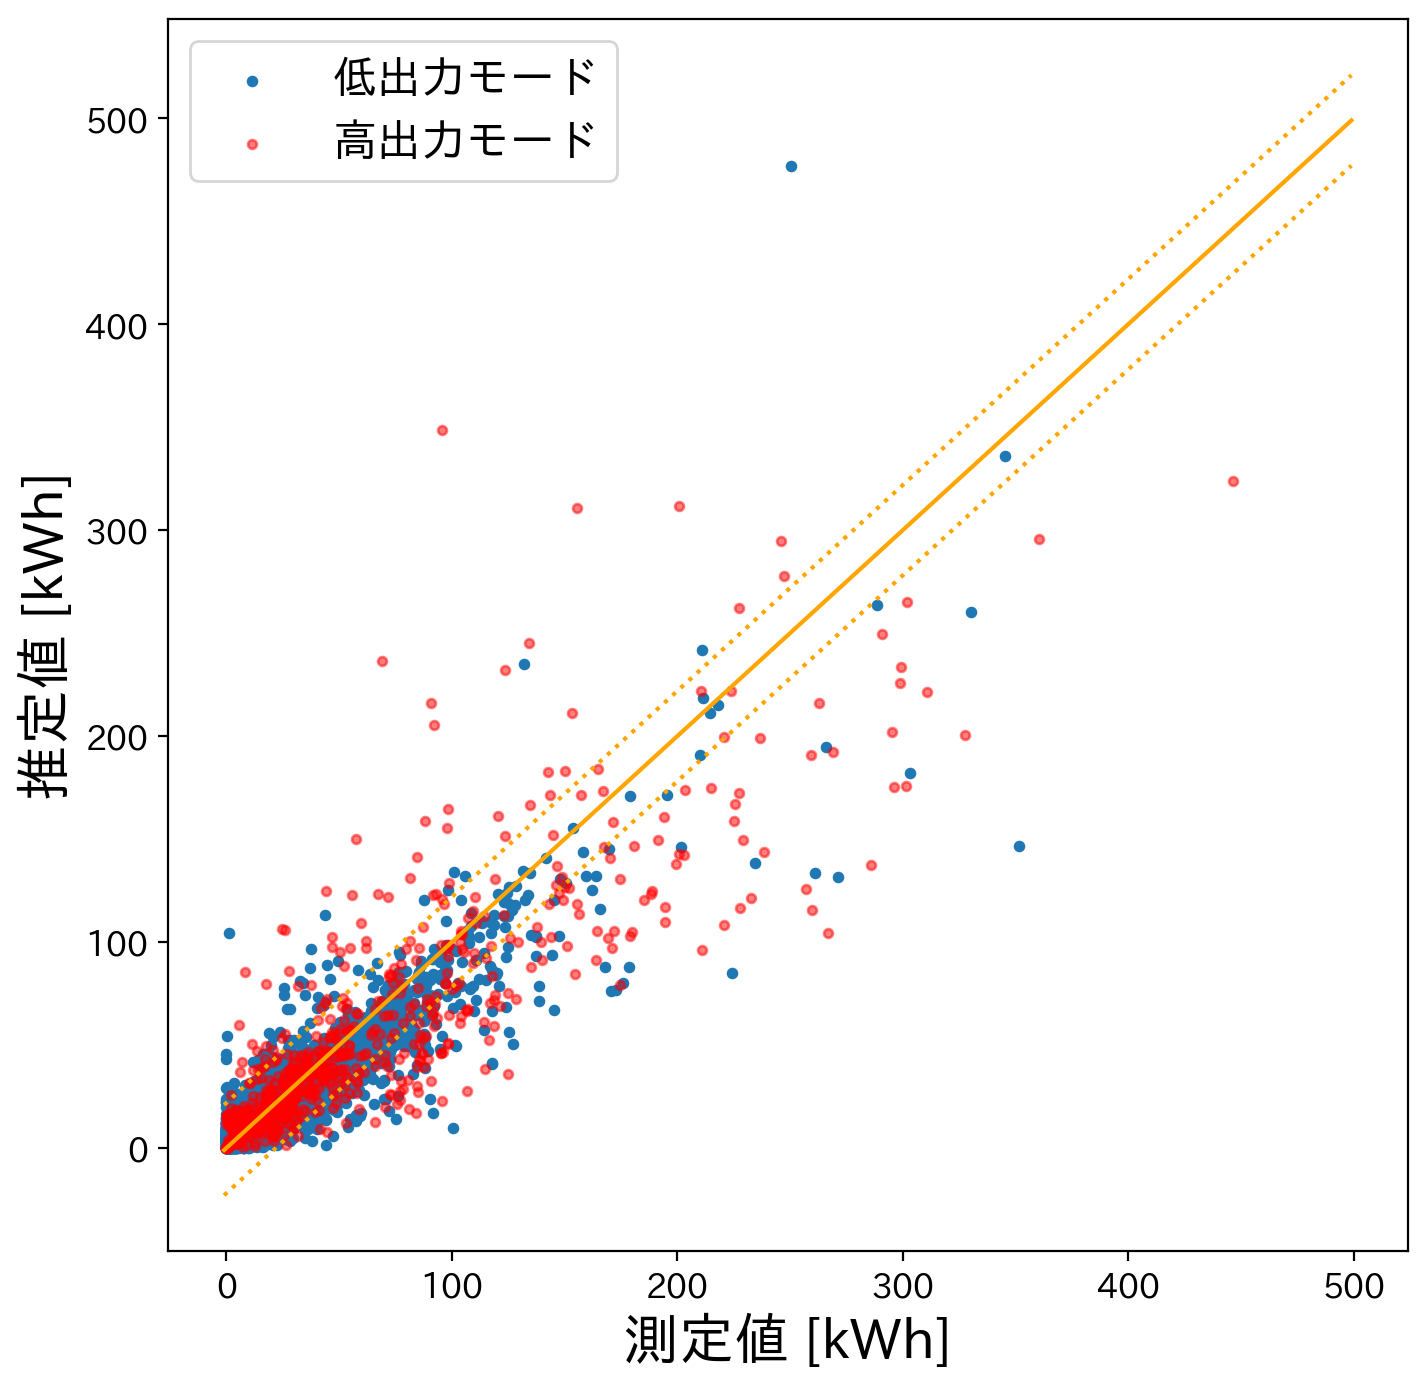

In [58]:
high_model = df_result[df_result['DROP_TIME'] != 0]
low_model = df_result[df_result['DROP_TIME'] == 0]
rmse = sqrt(mean_squared_error(df_result['Real_Wh'], df_result['Pred_Wh']))

plt.figure(figsize=(8, 8),dpi=200)
x = np.arange(-1, 500, 1)
y1 = x
plt.plot(x, y1, color='orange')
plt.plot(x, y1+2*rmse, color='orange', linestyle=':')
plt.plot(x, y1-2*rmse, color='orange', linestyle=':')

plt.scatter(low_model['Real_Wh'],low_model['Pred_Wh'],s=10,label='低出力モード')
plt.scatter(high_model['Real_Wh'],high_model['Pred_Wh'],s=10,c='r',alpha=0.5,label='高出力モード')

plt.xlabel('測定値 [kWh]',fontsize=20)
plt.ylabel('推定値 [kWh]',fontsize=20)
plt.legend(loc='upper left',fontsize=16)
plt.tick_params(labelsize=12)

plt.show()

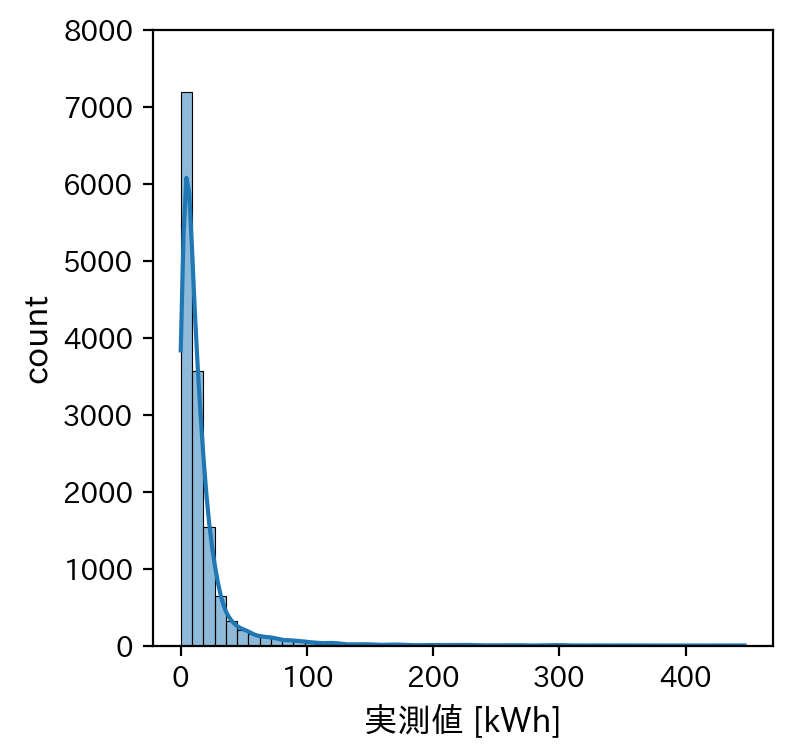

In [59]:
plt.figure(figsize=(4, 4),dpi=200)
sns.histplot(df_result['Real_Wh'], kde=True, bins=50)
plt.xlabel('実測値 [kWh]',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.ylim(0,8000)
plt.show()

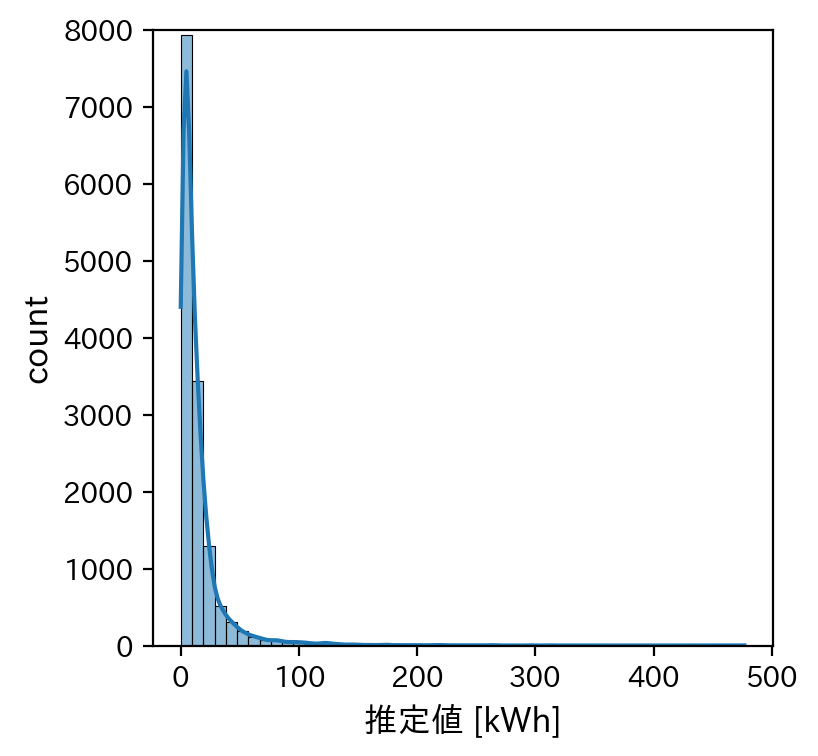

In [60]:
plt.figure(figsize=(4, 4),dpi=200)
sns.histplot(df_result['Pred_Wh'], kde=True, bins=50)
plt.xlabel('推定値 [kWh]',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.ylim(0,8000)
plt.show()

R2が高くないが、分布の再現ができたと言える。

In [61]:
print('実測値平均:',df_result['Real_Wh'].mean(),'実測値分散:',df_result['Real_Wh'].var())
print('推定値平均:',df_result['Pred_Wh'].mean(),'推定値分散:',df_result['Pred_Wh'].var())

実測値平均: 15.957200083400766 実測値分散: 667.6596219452024
推定値平均: 14.388395703719132 推定値分散: 509.01334200700643


In [62]:
print('実測値αβ:',calculate_alpha_beta(df_result['Real_Wh'].mean(),df_result['Real_Wh'].var()))
print('推定値αβ:',calculate_alpha_beta(df_result['Pred_Wh'].mean(),df_result['Pred_Wh'].var()))

実測値αβ: (41.8406498919397, 0.3813803113625825)
推定値αβ: (35.376657167931235, 0.4067200480649749)
